In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import numpy as np
import json
import pickle

#plt.style.use('https://pltstyle.s3.eu-west-1.amazonaws.com/zinc.mplstyle')
plt.style.use('https://pltstyle.s3.eu-west-1.amazonaws.com/light-gray.mplstyle')

plt.rcParams["font.family"] = "DM Mono"

# Overview of Analysis


To explore our features and their importance, we'll need to use the SHAP library to help explore our model.

For ease of use, we're going to be exploring our single target model. In order to implement the analysis with SHAP properly, we have to strip down our model to a certain extent. Within our modeling pipeline, we trained model our model with a transformed dataset that implemented scaling of numerical values and one-hot-encoding of categorical variables. To digest our model within SHAP, we need to see the original values of the data to better understand.

To do this, we can take the final trained model (at 'data/model/single_target_random_forest_model.pkl'), extract the hyperparameters, and train a new model on the original data prior to error the scaling.

For reference the RMSE for the different models is as follows:


|Error Metric      | Random Forest Muli-Output | Random Forest Single-Target | Random Forest Single-Target (no scaling or OH encoding) |
|------|:-------------------------:|:---------------------------:|:-------------------------------------------------------:|
|RMSE  |  7.787                    | (8.0136, 7.5610)            |  Home Team Only: 8.002                                  |



In [2]:
# Model loads for the supervised regression
# This model is the stripped down version with no scaling
# HOME TEAM ONLY
with open('data/model/rfr_for_shap.pkl', 'rb') as f:
    model_rfr = pickle.load(f)

In [3]:
x_train = pd.read_csv("data/output/model_rfr__x_train.csv")
x_train_disp = x_train.copy()
# DISPLAY MAPPINGS
x_train_disp.week_ind = x_train.week_ind.map({
    1: "MON",
    2: "SUN",
    3: "SAT",
    4: "FRI",
    5: "THU",
    6: "WED",
    7: "TUE"})

In [7]:
# Specify our regression training and test set for SHAP
# NOTE: This does not include the roof_type
FEATURE_SELECTION = [
    'week_ind', 'day_int',
    'attendance',
    'humidity_pct', 'wind_speed',
    'temperature', 'over_under_value',
    'spread_value', 'spread_home_away',
    'coach_rating', 'coach_rating_opp',
    'home_strength', 'opp_strength',
    'team_rating', 'team_rating_opp'
    ]

In [4]:
# Random Forest Explainer
rfr_explainer = shap.TreeExplainer(model_rfr,
                               feature_perturbation="interventional")

In [5]:
shap_explain = rfr_explainer(x_train)
shap_values = rfr_explainer.shap_values(x_train)

In [6]:
shap_values.shape

(2044, 15)

In [9]:
shap.initjs()
shap.force_plot(rfr_explainer.expected_value[0], shap_values[2], features=x_train_disp.iloc[2,:])

In [11]:
shap.initjs()
shap.force_plot(rfr_explainer.expected_value[0],
                shap_values[:100, :],
                features=x_train_disp.iloc[:100, :])

# Feature Analysis

We can better understand our model diving into the details of how it was constructed and where the different features rank. We are first showing the SHAP feature importance plot based on the training data.

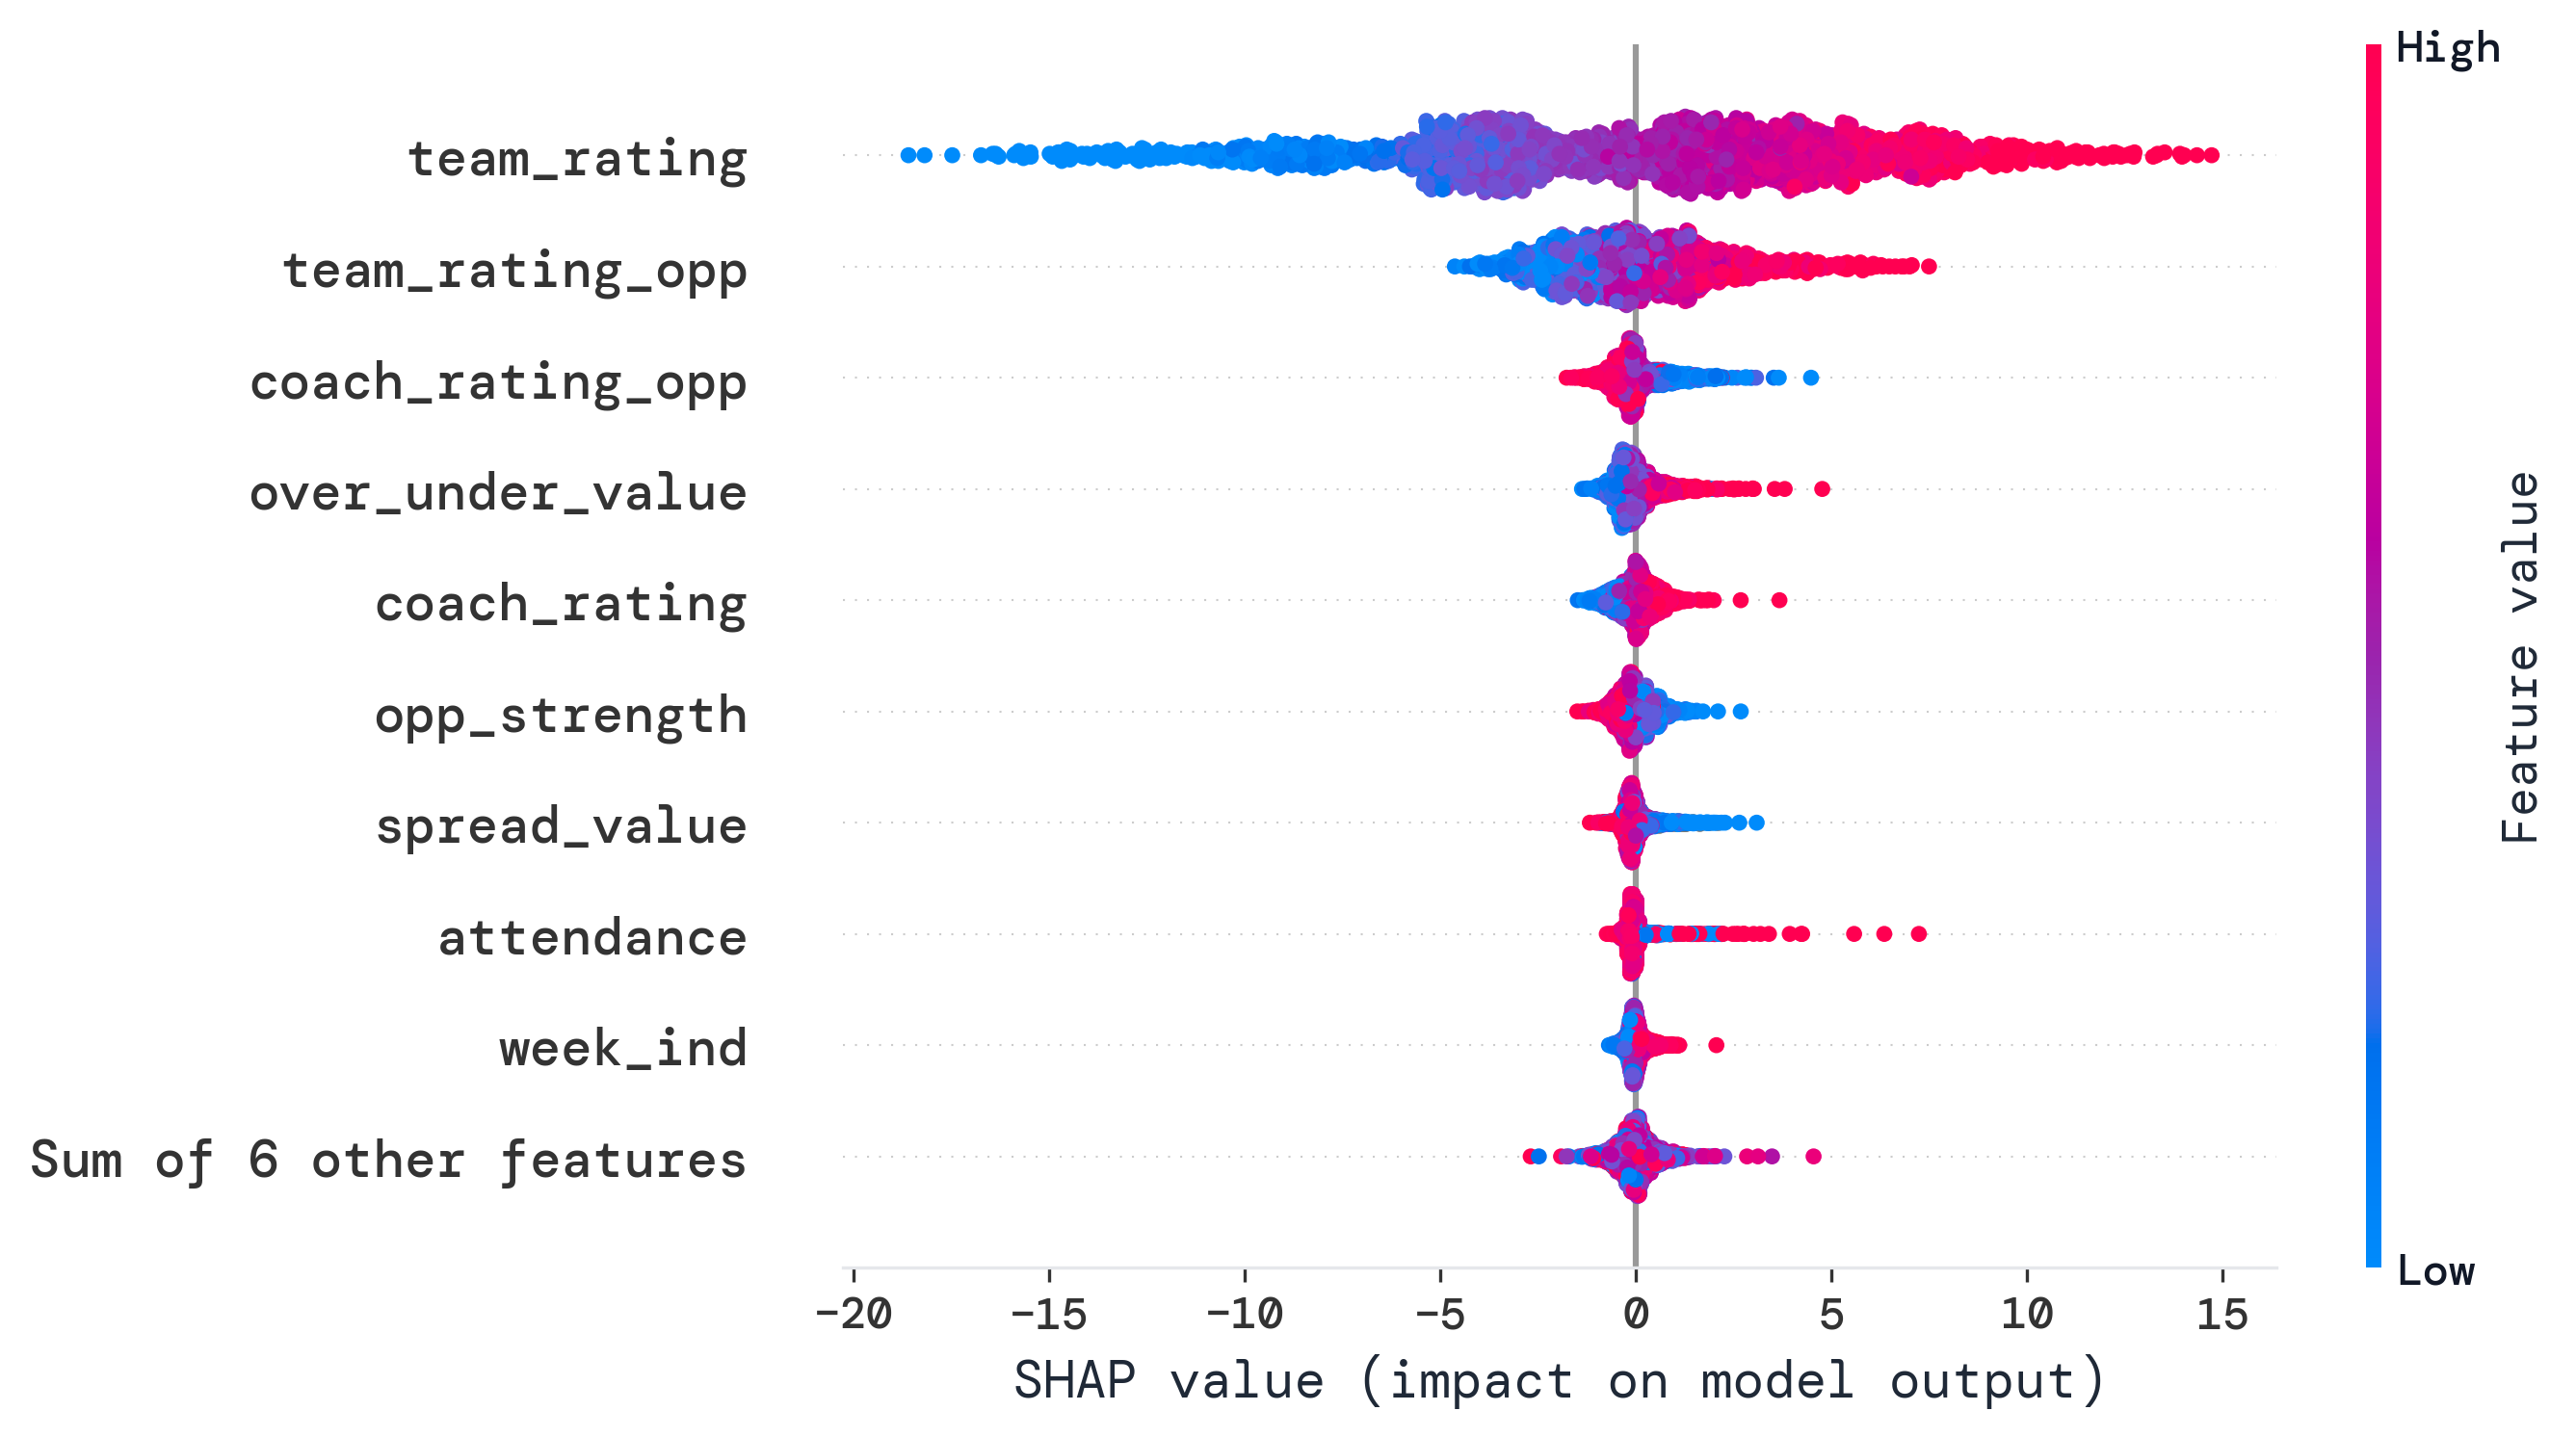

In [12]:
# Training Data Explanation

shap.plots.beeswarm(shap_explain[:, :])

The team rating for the home team (`team_rating`) is by far the most impactful predictor of the home team. This makes sense as it encompasses a lot of the different variables that make up a team and not just the strength of the players. The `home_strength` and `opp_strength` may be distilling the importance down too much.

We can explore more of this by looking at the test data and understanding how the model looked at some of the variables there.

In [13]:
# Read in our test data
# Explain the data based on our SHAP explainer
rfr_test = pd.read_csv("data/output/model_rfr__x_test.csv")
shap_test_explain = rfr_explainer(rfr_test)

In [15]:
# Load in the dataframe for our test set too and output the data from the 42nd game
rfr_results = pd.read_csv('data/output/random_forest_model_output.csv')
rfr_results.iloc[42,:]

Unnamed: 0                                 2086
game_id                      nyj_htx_2023-12-10
boxscore_stub       /boxscores/202312100nyj.htm
week_ind                                   14.0
day_int                                       2
attendance                              72956.0
roof_type                              outdoors
humidity_pct                               94.0
wind_speed                                  7.0
temperature                                58.0
over_under_value                           33.0
spread_value                               -3.0
spread_home_away                              0
coach_rating                          14.420266
coach_rating_opp                     101.483524
home_strength                         -28.59709
opp_strength                          -9.650731
team_rating                            168.7235
team_rating_opp                        89.53083
score_home_test                            30.0
score_opp_test                          

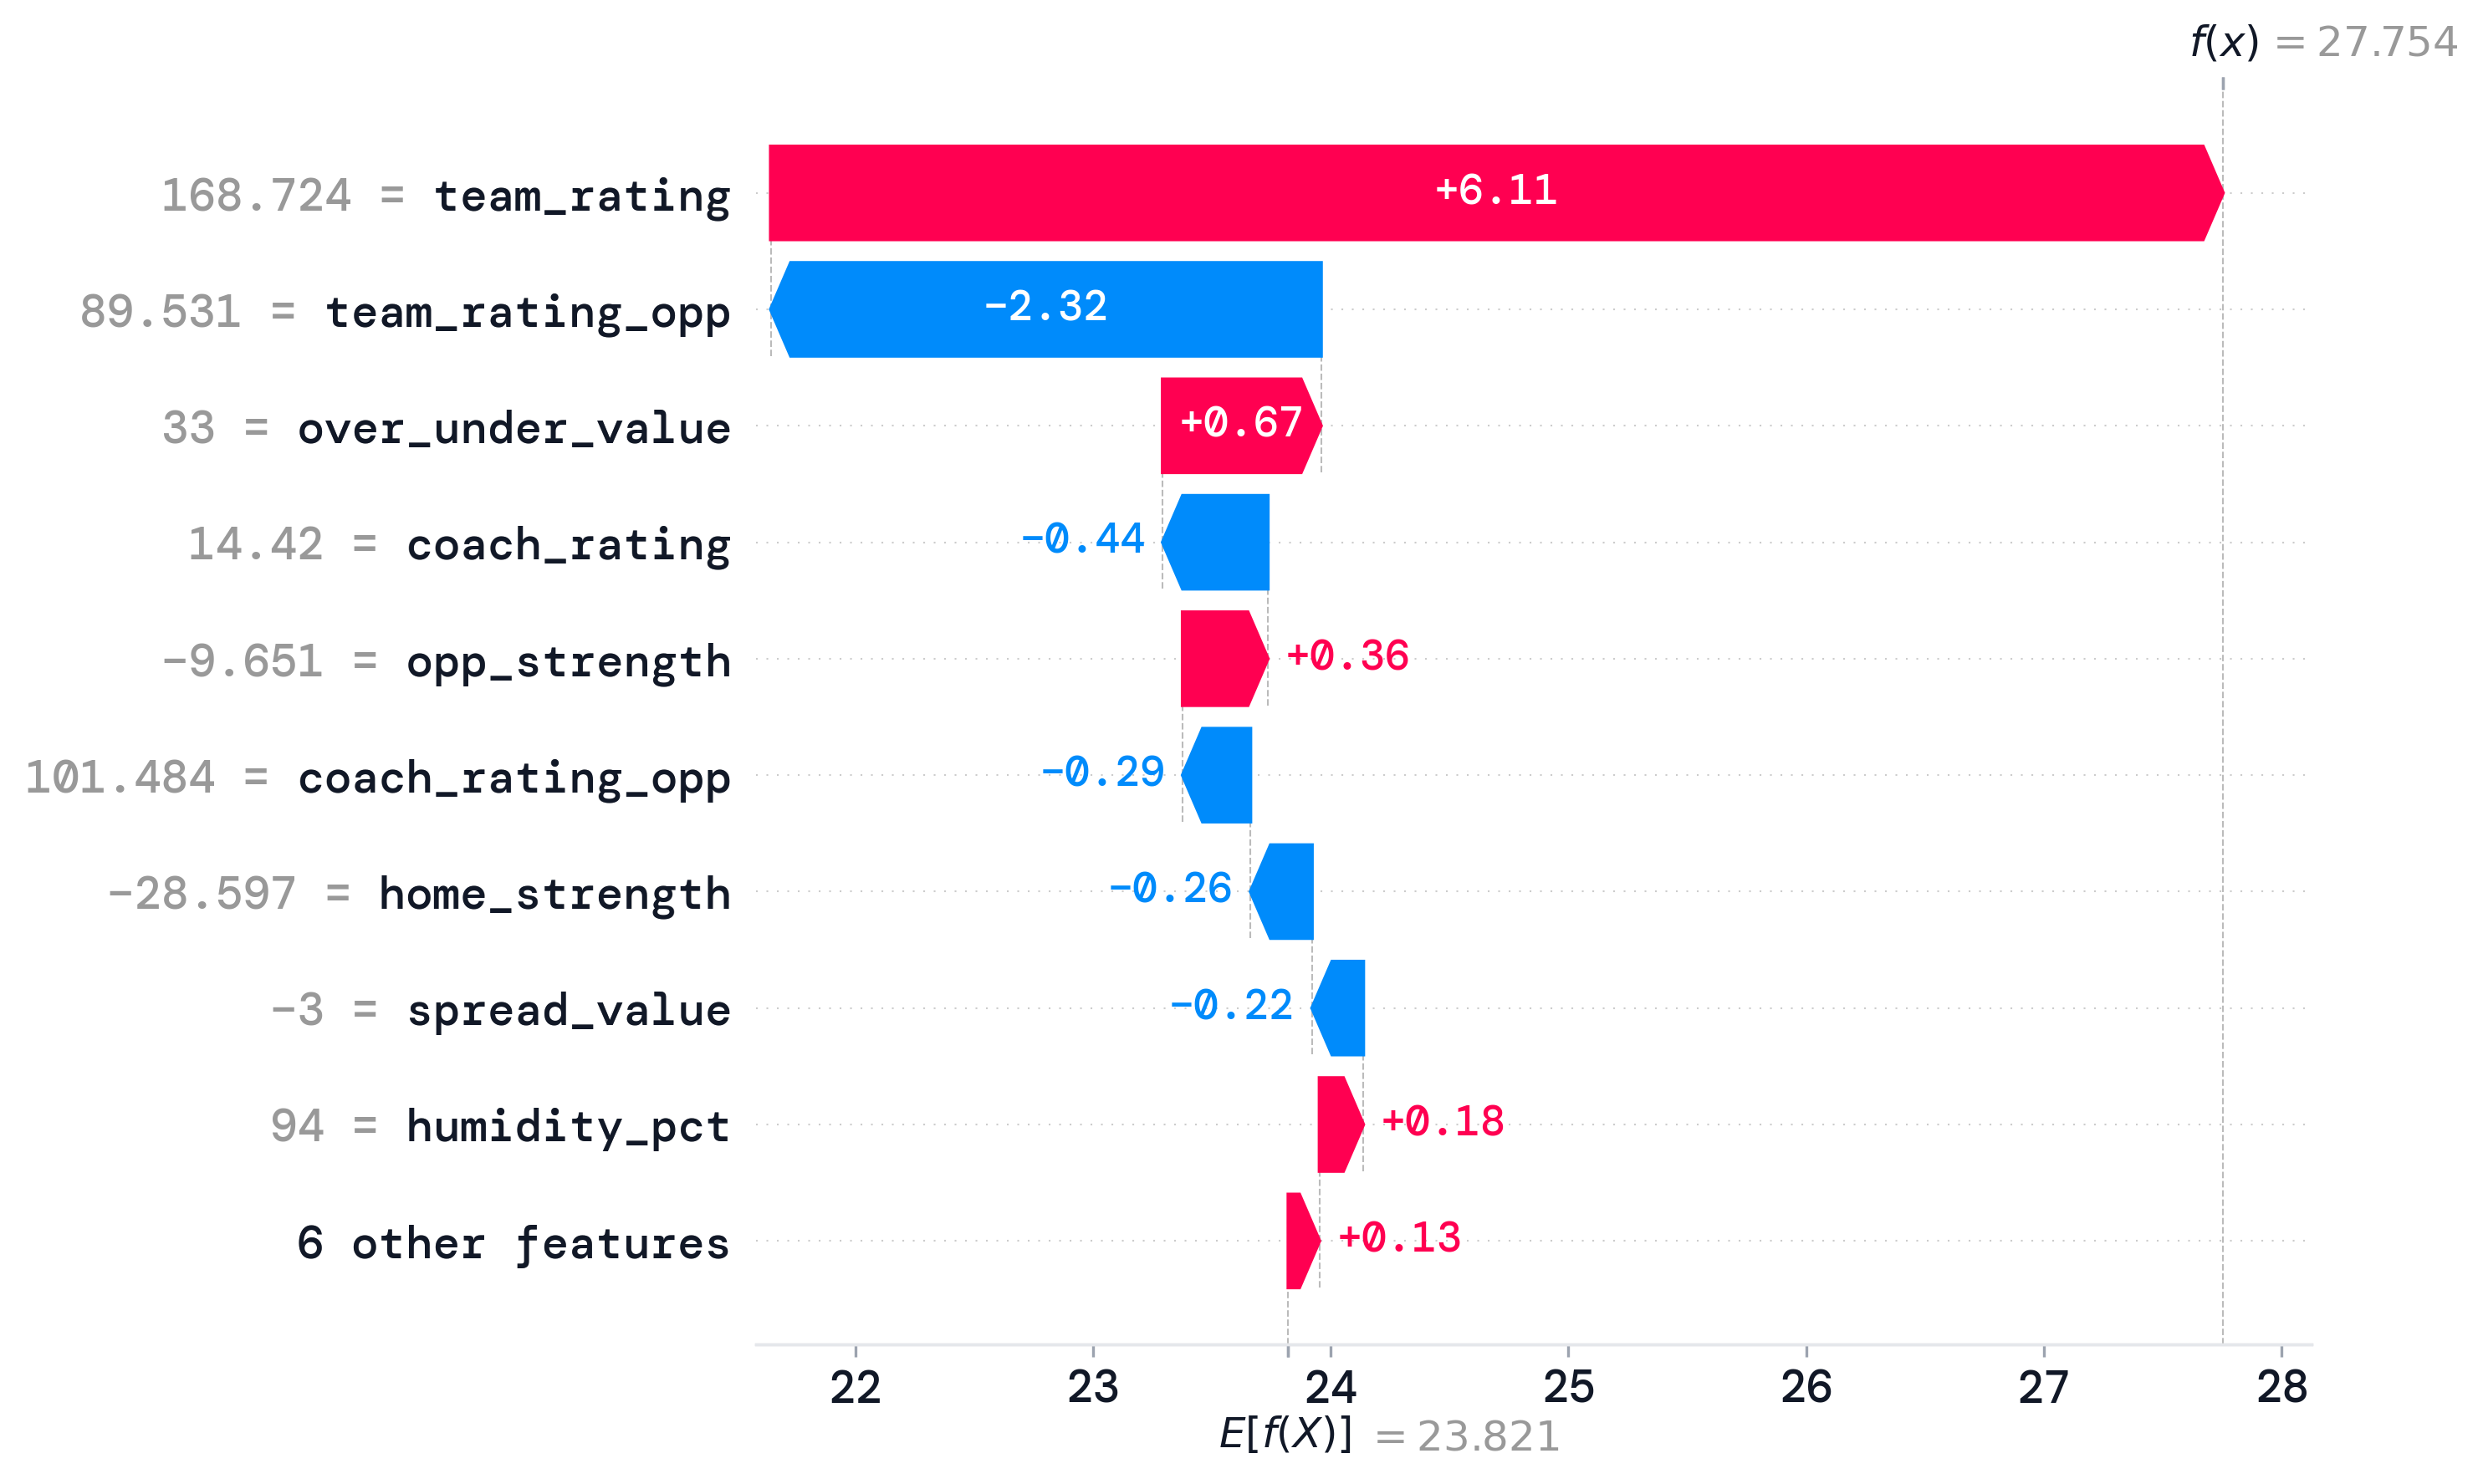

In [17]:
# What does the model say?
shap.plots.waterfall(shap_test_explain[42, :])